In [13]:
%reset -f
import statistics
import copy
import pandas as pd
import plotly.express as px

# The Model

In [19]:
# Define parameters:
DecayRate = 0.01           # The number of activation units lost every iteration (from each node)
ActivationStrength = 0.01  # The relation between unit activation and the activation it exerts through excitatory connections
InhibitionStrength = 0.01  # The relation between unit activation and the inhibition it exerts through inhibitory connections
BiasingMult = 1            # The relation between the relative ratio of competing low-level nodes and the activation they feed to the Conflict Monitoting unit

CongruentStroop = (0,0,0,60)     # Activation of FontColor, that supports Blue
IncongruentStroop = (0,0,20,30)  # Activation of FontColor, that supports Blue & Activation of TextColor, that supports Red
CongruentSentence = (60,0,0,0)   #
AnomalousSentence = (30,20,0,0)  #

max_iter = 10000 # Maximum number of iterations (per trial)
ActivationThreshold = 100 # Threshold activation level for a lower-level unit to be cosidered the final interpratation


In [14]:

CogCtrl=None
LingKnow=None
Stroop=None

class CognitiveControl(object):
    def __init__(self):
        self.ConflictMonitoring = 0
        self.Biasing = 0
 
    def Update(self,LingKnow,Stoop):
        # increase CM activity based on the relative ratio between SubjIsAgent & SubjIsTheme
        self.ConflictMonitoring += ActivationStrength*(abs(LingKnow.SubjIsAgent-LingKnow.SubjIsTheme)/(statistics.mean([LingKnow.SubjIsAgent,LingKnow.SubjIsTheme])+0.000001))
        # increase CM activity based on the relative ratio between Blue & Red
        self.ConflictMonitoring += ActivationStrength*(abs(Stroop.Blue-Stroop.Red)/(statistics.mean([Stroop.Blue,Stroop.Red])+0.000001))
        # increase B activation based on CM activation
        self.Biasing += ActivationStrength*self.ConflictMonitoring       
        # decay
        self.ConflictMonitoring -= DecayRate
        self.Biasing -= DecayRate      
        # prevent negative activation values
        if self.ConflictMonitoring < 0:
            self.ConflictMonitoring = 0
        if self.Biasing < 0:
            self.Biasing = 0

            
class LinguisticKnowledge(object):
    def __init__(self, WorldAct=0, MorphSyntAct=0):
        # Higher-Level
        self.WorldKnowledge = WorldAct
        self.MorphoSyntacticKnowledge = MorphSyntAct
        # Lower-Level
        self.SubjIsAgent = 0
        self.SubjIsTheme = 0
        
    def InputAct(self,WK,MSK):
        self.WorldKnowledge += WK
        self.MorphoSyntacticKnowledge += MSK

    def Update(self,CogCtrl,Stoop):        
        # save initial activations for calculations (to make sure all updating happens "at once")
        WorldKnowledgeInitialAct = self.WorldKnowledge
        MorphoSyntacticKnowledgeInitialAct = self.MorphoSyntacticKnowledge
        SubjIsAgentInitialAct = self.SubjIsAgent
        SubjIsThemeInitialAct = self.SubjIsTheme

        # increase WK & MSK activity based on CogCtrl.Biasing
        self.WorldKnowledge += (CogCtrl.Biasing*BiasingMult)
        self.MorphoSyntacticKnowledge += (CogCtrl.Biasing*BiasingMult)        
        
        # increase SubjIsAgent & SubjIsTheme based on WK & MSK
        self.SubjIsAgent += (MorphoSyntacticKnowledgeInitialAct*ActivationStrength) # SubjIsAgent is supported by WK
        self.SubjIsTheme += (WorldKnowledgeInitialAct*ActivationStrength) # SubjIsTheme is supported by MSK
        
        # lateral inhibition between SubjIsAgent & SubjIsTheme
        self.SubjIsAgent -= (SubjIsAgentInitialAct*InhibitionStrength)
        self.SubjIsTheme -= (SubjIsAgentInitialAct*InhibitionStrength)
        
        # decay
        self.WorldKnowledge -= DecayRate
        self.MorphoSyntacticKnowledge -= DecayRate
        self.SubjIsAgent -= DecayRate
        self.SubjIsTheme -= DecayRate
        # prevent negative activation values
        if self.WorldKnowledge < 0 :
            self.WorldKnowledge = 0
        if self.MorphoSyntacticKnowledge <0:
            self.MorphoSyntacticKnowledge = 0
        if self.SubjIsAgent < 0:
            self.SubjIsAgent = 0
        if self.SubjIsTheme < 0:
            self.SubjIsTheme = 0

        
class StroopTaskRepresentation(object):
    def __init__(self, TextAct=0, FontColAct=0):
        # Higher-Level
        self.Text = TextAct
        self.FontColor = FontColAct
        # Lower-Level
        self.Blue = 0
        self.Red = 0
            
    def InputAct(self,Text,FontColor):
        self.Text += Text
        self.FontColor += FontColor
        

    def Update(self,CogCtrl,LingKnow):
        # save initial activations for calculations (to make sure all updating happens "at once")
        TextInitialAct = self.Text
        FontColorInitialAct = self.FontColor
        BlueInitialAct = self.Blue
        RedInitialAct = self.Red
        
        # increase Text & FontColor activity based on CogCtrl.Biasing
        self.Text += (CogCtrl.Biasing*BiasingMult)
        self.FontColor += (CogCtrl.Biasing*BiasingMult)

        # increase Blue & Red based activity based on Text & FontColor
        self.Blue += (FontColorInitialAct*ActivationStrength) # Blue is supported by FontColor
        self.Red += (TextInitialAct*ActivationStrength) # Red is supported by Text

        # lateral inhibition between Blue & Red
        self.Blue -= (RedInitialAct*InhibitionStrength)
        self.Red -= (BlueInitialAct*InhibitionStrength)
        
        # decay
        self.Text -= DecayRate
        self.FontColor -= DecayRate
        self.Blue -= DecayRate
        self.Red -= DecayRate
        # prevent negative activation values
        if self.Text < 0:
            self.Text = 0
        if self.FontColor <0:
            self.FontColor = 0
        if self.Blue < 0:
            self.Blue = 0
        if self.Red < 0:
            self.Red = 0

        

def UpdateAll(CogCtrl,LingKnow,Stroop):    
    CogCtrl_prev = copy.copy(CogCtrl)
    LingKnow_prev = copy.copy(LingKnow)
    Stroop_prev = copy.copy(Stroop)

    CogCtrl.Update(LingKnow_prev,Stroop_prev)
    LingKnow.Update(CogCtrl_prev,Stroop_prev)
    Stroop.Update(CogCtrl_prev,LingKnow_prev)
    return [CogCtrl, LingKnow, Stroop]


def RunTrial(InputAct:tuple,CC=None,LK=None,S=None):
    '''
    InputAct specifies the input activations for WK,MSK,Text,FontColor (in that order).
    '''
    i = 1

    global CogCtrl
    global LingKnow
    global Stroop

    if CC == None:
        CogCtrl = CognitiveControl()
    else:
        CogCtrl = CC
        
    if LK == None:
        LingKnow = LinguisticKnowledge()
    else:
        LingKnow = LK
        
    if S == None:
        Stroop = StroopTaskRepresentation()
    else:
        Stroop = S
        

    LingKnow.InputAct(InputAct[0],InputAct[1])
    Stroop.InputAct(InputAct[2],InputAct[3])

    while i <= max_iter:
        UpdateAll(CogCtrl,LingKnow,Stroop)
        i += 1
        MaxAct = max(LingKnow.SubjIsAgent,LingKnow.SubjIsTheme,Stroop.Blue,Stroop.Red)
        if MaxAct > ActivationThreshold:
            break
    
    # determine the final interpratation
    if [LingKnow.SubjIsAgent,LingKnow.SubjIsTheme,Stroop.Blue,Stroop.Red].count(MaxAct) > 1:
        Winner = None
    if LingKnow.SubjIsAgent == MaxAct:
        Winner = 'SubjIsAgent'
    if LingKnow.SubjIsTheme == MaxAct:
        Winner = 'SubjIsTheme'
    if Stroop.Blue == MaxAct:
        Winner = 'Blue'
    if Stroop.Red == MaxAct:
        Winner = 'Red'
    
    return i, Winner, CogCtrl, LingKnow, Stroop


def RunTrialSequence(Trials:"list of tuples"):
    '''
    Trials is a list of tuples.
    Each tuple consists of 4 values that are the input activations of WK,MSK,Text,FontColor (in that order) in a specific trial.
    '''
    CogCtrl = CognitiveControl()
    LingKnow = LinguisticKnowledge()
    Stroop = StroopTaskRepresentation()
    
    Results = []
    for Trial in Trials:
        i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(Trial,CogCtrl,LingKnow,Stroop)
        Results.append([i,Winner])
        # reset Lang & stroop activations
        
    return Results

# Cognitive control makes conflict resolution faster

## In Stroop

173 Blue
172 Blue
398 Blue
354 Blue


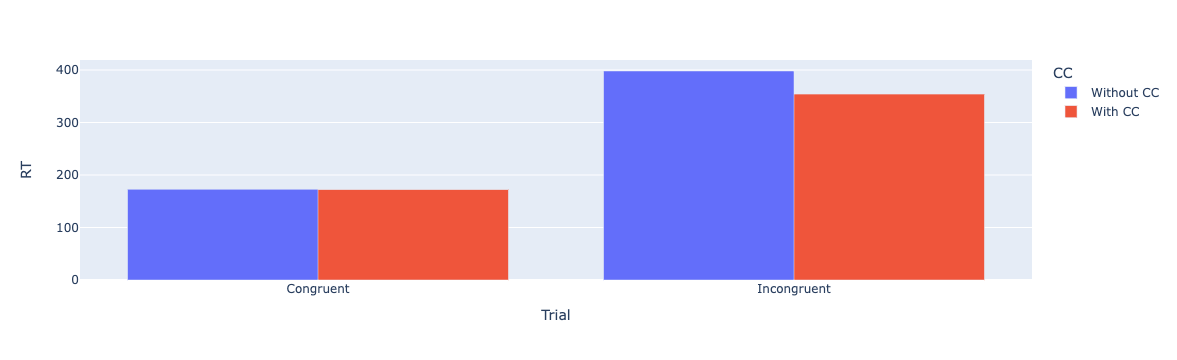

In [15]:
# Congruent Stroop trial with BiasingMult = 0
BiasingMult = 0
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(CongruentStroop)
RT_CongStroop_NoCC = i
print(i, Winner)

# Congruent Stroop trial with BiasingMult = 1
BiasingMult = 1
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(CongruentStroop)
RT_CongStroop_WithCC = i
print(i, Winner)

# Inongruent Stroop trial with BiasingMult = 0
BiasingMult = 0
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(IncongruentStroop)
RT_IncongStroop_NoCC = i
print(i, Winner)

# Incongruent Stroop trial with BiasingMult = 1
BiasingMult = 1
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(IncongruentStroop)
RT_IncongStroop_WithCC = i
print(i, Winner)

# Figure
df = pd.DataFrame({'CC':['Without CC','With CC','Without CC','With CC'],
                   'Trial':['Congruent','Congruent','Incongruent','Incongruent'],
                   'RT':[RT_CongStroop_NoCC,RT_CongStroop_WithCC,RT_IncongStroop_NoCC,RT_IncongStroop_WithCC]})

fig = px.bar(df,x='Trial',y='RT',color='CC',barmode="group")
fig.show()


Cognitive control makes incongruent Stroop trials faster (and does not affect congruent trials).

## In Language

173 SubjIsTheme
172 SubjIsTheme
890 SubjIsTheme
839 SubjIsTheme


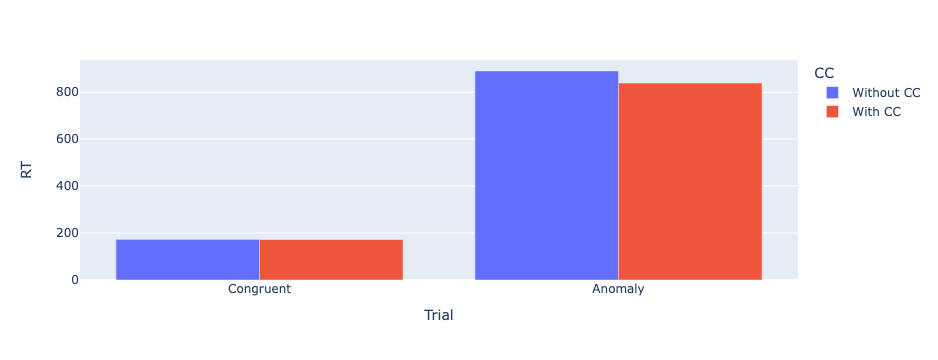

In [16]:
# Control sentence trial with BiasingMult = 0
BiasingMult = 0
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(CongruentSentence)
RT_CongLang_NoCC = i
print(i, Winner)

# control sentence trial with BiasingMult = 1
BiasingMult = 1
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(CongruentSentence)
RT_CongLang_WithCC = i
print(i, Winner)

# Anomalous sentence trial with BiasingMult = 0
BiasingMult = 0
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(AnomalousSentence)
RT_AnomLang_NoCC = i
print(i, Winner)

# Anomalous sentence trial with BiasingMult = 1
BiasingMult = 1
i, Winner, CogCtrl, LingKnow, Stroop = RunTrial(AnomalousSentence)
RT_AnomLang_WithCC = i
print(i, Winner)

# Figure
df = pd.DataFrame({'CC':['Without CC','With CC','Without CC','With CC'],
                   'Trial':['Congruent','Congruent','Anomaly','Anomaly'],
                   'RT':[RT_CongLang_NoCC,RT_CongLang_WithCC,RT_AnomLang_NoCC,RT_AnomLang_WithCC]})

fig = px.bar(df,x='Trial',y='RT',color='CC',barmode="group")
fig.show()

The same cognitive control system also makes trials with linguistic conflict faster (and does not affect control sentences).

# Cross-Task Adaptation

[[172, 'Blue'], [2, 'Blue']]
[[354, 'Blue'], [2, 'Blue']]
[[172, 'Blue'], [2, 'Blue']]
[[354, 'Blue'], [2, 'Blue']]


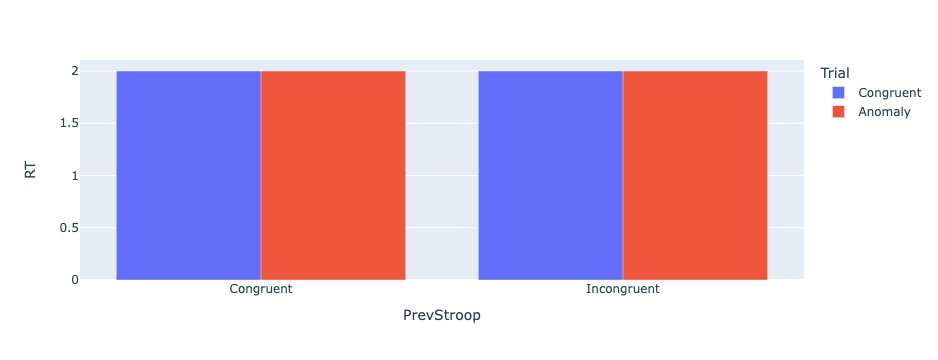

In [18]:
# A Congruent Stroop -> Control Sentence sequence
Results = RunTrialSequence((CongruentStroop,CongruentSentence))
RT_CongCong = Results[1][0]
print(Results)

# An Inongruent Stroop -> Control Sentence sequence
Results = RunTrialSequence((IncongruentStroop,CongruentSentence))
RT_IncongCong = Results[1][0]
print(Results)

# A Congruent Stroop -> Anomalous Sentence sequence
Results = RunTrialSequence((CongruentStroop,AnomalousSentence))
RT_CongAnom = Results[1][0]
print(Results)

# An Incongruent Stroop -> Anomalous Sentence sequence
Results = RunTrialSequence((IncongruentStroop,AnomalousSentence))
RT_IncongAnom = Results[1][0]
print(Results)

# Figure
df = pd.DataFrame({'PrevStroop':['Congruent','Incongruent','Congruent','Incongruent'],
                   'Trial':['Congruent','Congruent','Anomaly','Anomaly'],
                   'RT':[RT_CongCong,RT_IncongCong,RT_CongAnom,RT_IncongAnom]})

fig = px.bar(df,x='PrevStroop',y='RT',color='Trial',barmode="group")
fig.show()

The engagment of cognitive control in an Incongruent Stroop Trial makes the subsequent Anomalous Sentence trial faster (but does not affect Control Sentences).

# Possible Additional Figures
Activation levels of a node throughout a trial - this information is currently not saved. Needs to be changed if we want that.